In [1]:
import os
from ModularCirc.Models.KorakianitisMixedModel import KorakianitisMixedModel, KorakianitisMixedModel_parameters, TEMPLATE_TIME_SETUP_DICT
from ModularCirc import BatchRunner
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pickle
from cvdnet_pipeline.utils import helper_functions, plot_utils

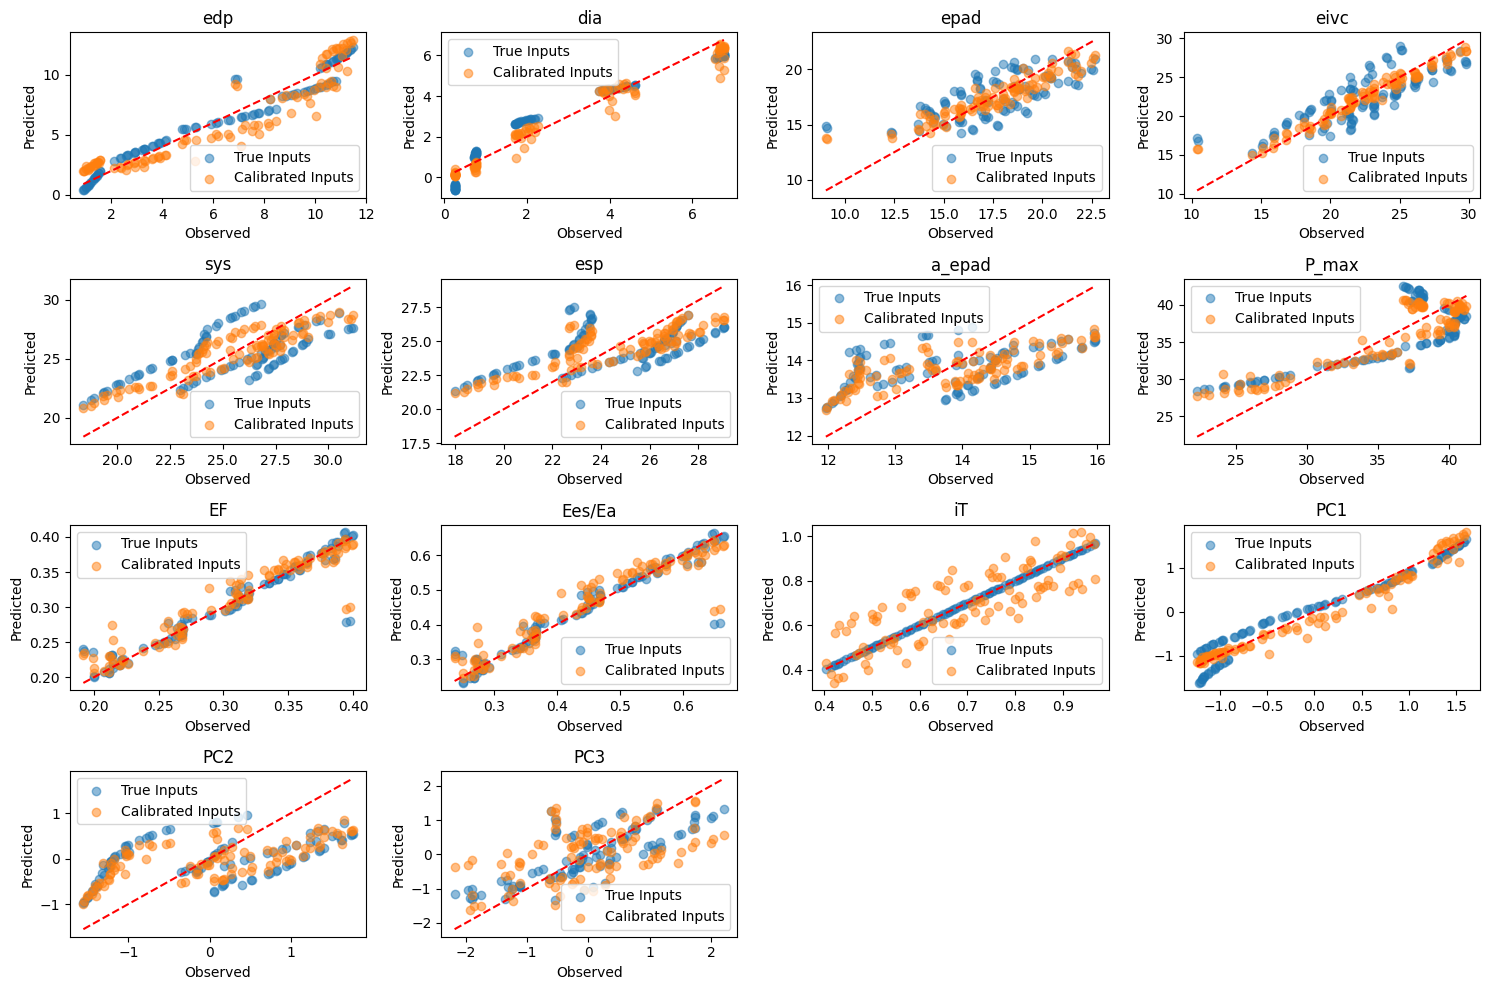

In [13]:
n_samples = 100
n_params = 9
data_type = "synthetic"
output_path = "output_synthetic"

all_output_keys = [
        "edp",
        "dia",
        "epad",
        "eivc",
        "sys",
        "esp",
        "a_epad",
        "P_max",
        "EF",
        "Ees/Ea",
        "iT",
        "PC1",
        "PC2",
        "PC3"
    ]

calibration_path = "14_output_keys/kf_calibration_results/14_output_keys/calibration_20250924_152801/kf_estimated_means"

# Emulators
emulators= pd.read_pickle(f"{output_path}/output_{n_samples}_{n_params}_params/emulators/linear_models_and_r2_scores_{n_samples}.pkl")

# True imputs
true_inputs = pd.read_csv(f"{output_path}/pure_input_{n_samples}_{n_params}_params.csv")

# True outputs
true_output = pd.read_csv(f"{output_path}/output_{n_samples}_{n_params}_params/waveform_resampled_all_pressure_traces_rv_with_pca.csv")

# Calibrated inputs
calibrated_inputs = pd.read_csv(f"{output_path}/output_{n_samples}_{n_params}_params/kf_calibration_results/{calibration_path}.csv")

# Select emulators and data for specified output_keys
emulator_output = emulators.loc[all_output_keys]
observation_data = true_output.loc[:, all_output_keys] 

# Construct beta matrix and intercepts
beta_matrix = []
intercept = []

for _, row_entry in emulator_output.iterrows():
    model = row_entry['Model']
    beta_matrix.append(model.coef_)
    intercept.append(model.intercept_)

beta_matrix = np.array(beta_matrix)
intercept = np.array(intercept).reshape(len(intercept), 1)

# emulator predictions for true inputs
emulator_predictions_true = np.dot(beta_matrix, true_inputs.T) + intercept
emulator_predictions_true = pd.DataFrame(emulator_predictions_true.T, columns=all_output_keys)

# emulator predictions for calibrated inputs
emulator_predictions_calibrated = np.dot(beta_matrix, calibrated_inputs.T) + intercept  
emulator_predictions_calibrated = pd.DataFrame(emulator_predictions_calibrated.T, columns=all_output_keys)

# Plot results
plt.figure(figsize=(15, 10))
for i, key in enumerate(all_output_keys):
    plt.subplot(4, 4, i+1)
    plt.scatter(observation_data[key], emulator_predictions_true[key], label='True Inputs', alpha=0.5)
    plt.scatter(observation_data[key], emulator_predictions_calibrated[key], label='Calibrated Inputs', alpha=0.5)
    plt.plot([observation_data[key].min(), observation_data[key].max()], 
             [observation_data[key].min(), observation_data[key].max()], 'r--')
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.title(key)
    plt.legend()
plt.tight_layout()





In [9]:
emulator_predictions_true.head()

,edp,dia,epad,eivc,sys,esp,a_epad,P_max,EF,Ees/Ea,iT,PC1,PC2,PC3
0,0.617833,-0.597669,19.556650,27.630638,29.037815,27.023093,13.933269,42.223254,0.373170,0.588551,0.509691,-1.543441,-0.057942,-0.788645
1,1.379473,-0.455976,16.668331,23.343926,27.064628,25.592816,13.280184,41.279927,0.391301,0.629021,0.751618,-1.296052,-0.556706,0.359939
2,1.631055,-0.409172,15.714269,21.927951,26.412850,25.120371,13.064459,40.968330,0.397290,0.642389,0.831531,-1.214335,-0.721456,0.739336
3,1.091419,-0.509565,17.760698,24.965168,27.810890,26.133749,13.527182,41.636695,0.384444,0.613715,0.660121,-1.389615,-0.368072,-0.074457
4,1.860789,-0.366433,14.843066,20.634950,25.817678,24.688956,12.867469,40.683794,0.402759,0.654596,0.904503,-1.139715,-0.871899,1.085784


In [10]:
emulator_predictions_calibrated.head()

,edp,dia,epad,eivc,sys,esp,a_epad,P_max,EF,Ees/Ea,iT,PC1,PC2,PC3
0,2.432024,0.399865,18.296340,25.071614,27.537164,25.947711,13.740227,40.074617,0.357547,0.557847,0.619228,-1.040697,-0.162413,-0.283596
1,2.676712,0.277314,15.937443,21.745975,26.088541,24.894517,13.183441,39.746521,0.378348,0.603215,0.815798,-0.939186,-0.598571,0.653471
2,2.722894,0.199373,15.025564,20.482875,25.549443,24.502126,12.965202,39.676432,0.387157,0.622332,0.891657,-0.912842,-0.770874,1.015586
3,2.427725,0.134826,16.062889,22.032476,26.267440,25.022390,13.198412,40.040577,0.380989,0.608503,0.804712,-1.007453,-0.593397,0.603022
4,2.673213,0.141381,14.798907,20.197336,25.441845,24.423219,12.907162,39.730702,0.390318,0.629080,0.910348,-0.922588,-0.818372,1.105434
